# EV SSM Model

This  notebook is used to reproduce the State Space Model of aggregateed EV for frequency regulation.

Running on Jinning's local machine, in the env "ev".

Working notes:

02/06/2022: the EV data generation is completed. It looks weired, we may need update it later on.


In [2]:
import andes
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

print(f"ANDES Version: {andes.__version__}")

ANDES Version: 1.5.10.post8.dev0+g8a4acd78


## EV data

### Define parameters

The EV parameters are defined as two types. Type I follows uniform distribution, which is stored in a Dict `ev_param`. Type II follows normal distribution, which is stored in a pd.DataFrame `ev_pdf`.

The data are cited from:

M. Wang et al., "State Space Model of Aggregated Electric Vehicles for Frequency Regulation," in IEEE Transactions on Smart Grid, vol. 11, no. 2, pp. 981-994, March 2020, doi: 10.1109/TSG.2019.2929052.

In [3]:
#  rated charging/discharging power, charging/discharging efficiency, battery capacity follow uniform distribution
ev_param = dict(
  N=10000,      # Number of EV
  Ns=20,        # Number of SoC intervals
  Pl = 5.0,     # Rated charging/discharging power (kW) lower bound
  Pu = 7.0,     # Rated charging/discharging power (kW) upper bound
  nl = 0.88,    # charging/discharging efficiency lower bound
  nu = 0.95,    # charging/discharging efficiency upper bound
  Ql = 20.0,    # Battery capacity (kWh) lower bound
  Qu = 30.0,    # Battery capacity (kWh) upper bound
  socl = 0,     # Minimum SoC value
  socu= 1,      # Maximum SoC value
)

#  soc intervals
unit = ev_param['socu']/ev_param['Ns']
intv = {}
decimal = 4
for i in range(ev_param['Ns']):
    intv_single = [np.around(i*unit, decimal), np.around((i+1)*unit, decimal)]
    intv[i] = intv_single
print(f"SoC are seperated into Ns(={ev_param['Ns']}) intervals:")
print(intv)

#  others follow normal distribution
ev_pdf_name = ['soci', 'socd', 'ti1', 'ti2', 'tf1', 'tf2']
ev_pdf_data = {
    'mean':     [0.3, 0.8, -6.5, 17.5, 8.9, 32.9],
    'var':      [0.05, 0.03, 3.4, 3.4, 3.4, 3.4],
    'lb':       [0.2, 0.7, 0.0, 5.5, 0.0, 20.9],
    'ub':       [0.4, 0.9, 5.5, 24.0, 20.9, 24.0],
    'comment':  ['initial SoC', 'demanded SoC', 'start charging time 1', 'start charging time 2',
                 'finish charging time 1', 'finish charging time 2'],
    }
ev_pdf = pd.DataFrame(data = ev_pdf_data, index =ev_pdf_name).transpose()
print("Parameters that follow a normal distribution is stored in ``ev_pdf``:")
ev_pdf

SoC are seperated into Ns(=20) intervals:
{0: [0.0, 0.05], 1: [0.05, 0.1], 2: [0.1, 0.15], 3: [0.15, 0.2], 4: [0.2, 0.25], 5: [0.25, 0.3], 6: [0.3, 0.35], 7: [0.35, 0.4], 8: [0.4, 0.45], 9: [0.45, 0.5], 10: [0.5, 0.55], 11: [0.55, 0.6], 12: [0.6, 0.65], 13: [0.65, 0.7], 14: [0.7, 0.75], 15: [0.75, 0.8], 16: [0.8, 0.85], 17: [0.85, 0.9], 18: [0.9, 0.95], 19: [0.95, 1.0]}
Parameters that follow a normal distribution is stored in ``ev_pdf``:


,soci,socd,ti1,ti2,tf1,tf2
mean,0.3,0.8,-6.5,17.5,8.9,32.9
var,0.05,0.03,3.4,3.4,3.4,3.4
lb,0.2,0.7,0.0,5.5,0.0,20.9
ub,0.4,0.9,5.5,24.0,20.9,24.0
comment,initial SoC,demanded SoC,start charging time 1,start charging time 2,finish charging time 1,finish charging time 2


### Generate EV dataset

The generated EV data are stored in a pd.DataFrame ``ev_data``:

| Parameter | Definition                      |
|-----------|---------------------------------|
| Pc/Pd     | charging/discharging rate       |
| nc/nd     | charging/discharging efficiency |
| Q         | capacity                        |
| soci/socd | initial/demand SoC level        |
| ti/tf     | start/finish time               |

In [4]:
#  store the EV data in a df
ev_data = pd.DataFrame()

np.random.seed(2021)  # set the random seed

#  data from uniform distribution
cols = ['Pc', 'Pd', 'nc', 'nd', 'Q']
cols_bound = {
    'Pc':   ['Pl', 'Pu'],
    'Pd':   ['Pl', 'Pu'],
    'nc':   ['nl', 'nu'],
    'nd':   ['nl', 'nu'],
    'Q':    ['Ql', 'Qu'],
}

for col in cols:
    idxl = cols_bound[col][0]
    idxh = cols_bound[col][1]
    ev_data[col] = np.random.uniform(low=ev_param[idxl], high=ev_param[idxh], size=ev_param['N'])

#  data from normal distribution
for col in ev_pdf_name[0:2]:
    ev_data[col] = stats.truncnorm(
                    (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'], 
                    (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                    loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(ev_param['N'])

#  data from ref1 is confusing, now data from ref2 is used. 02/06/2022

#  data from ref1
#  there are two types of ti/tf, ratio_t1 is used to control the proportion of ti1/tf1

# initialization
ratio_t1 = 0.5
amt1 = int(ev_param['N']*ratio_t1)
amt2 = ev_param['N'] - amt1
col = 'ti1'
ti1 = stats.truncnorm(
                (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'], 
                (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(amt1)
col = 'tf1'
tf1 = stats.truncnorm(
                (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'], 
                (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(amt1)
col = 'ti2'
ti2 = stats.truncnorm(
                (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'], 
                (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(amt2)
col = 'tf2'
tf2 = stats.truncnorm(
                (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'], 
                (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(amt2)

ti = np.concatenate((ti1, ti2))
tf = np.concatenate((tf1, tf2))
np.random.shuffle(ti)
np.random.shuffle(tf)

ev_data['ti'] = ti
ev_data['tf'] = tf

# while loop
ncount = 0
bad_amount = ev_data[ev_data['ti'] > ev_data['tf']].shape[0]
while ncount < 100 and bad_amount > 0:
    ncount += 1
    # print(f"Loop {ncount}")
    amt1 = int(bad_amount * ratio_t1)
    amt2 = bad_amount - amt1

    col = 'ti1'
    ti1 = stats.truncnorm(
                    (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'], 
                    (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                    loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(amt1)
    col = 'tf1'
    tf1 = stats.truncnorm(
                    (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'], 
                    (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                    loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(amt1)
    col = 'ti2'
    ti2 = stats.truncnorm(
                    (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'], 
                    (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                    loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(amt2)
    col = 'tf2'
    tf2 = stats.truncnorm(
                    (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'], 
                    (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                    loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(amt2)
    
    ti = np.concatenate((ti1, ti2))
    tf = np.concatenate((tf1, tf2))
    np.random.shuffle(ti)
    np.random.shuffle(tf)

    old_idx = ev_data['ti'][ev_data['ti'] > ev_data['tf']].index
    ev_data['ti'][old_idx] = ti
    ev_data['tf'][old_idx] = tf

    bad_amount = ev_data[ev_data['ti'] > ev_data['tf']].shape[0]

#  data consistance check:
#  1) soci <= socd; 2) ti <= tf
cond1 = ev_data[ev_data['soci'] > ev_data['socd']].shape[0] == 0
cond2 = ev_data[ev_data['ti'] > ev_data['tf']].shape[0] == 0
if cond1 and cond2:
    print("Consistency check passed.")

#  sample data
ev_data.head()

Consistency check passed.


,Pc,Pd,nc,nd,Q,soci,socd,ti,tf
0,6.211957,5.510671,0.906904,0.880400,21.677801,0.305890,0.818166,12.683174,23.807004
1,6.466739,6.283294,0.922561,0.918585,29.654122,0.312636,0.801906,0.411095,21.917349
2,5.277894,6.471517,0.900035,0.934780,23.550309,0.358089,0.755766,0.219800,13.185378
3,5.625346,6.125349,0.909166,0.942975,23.177159,0.281295,0.832347,1.398694,23.220399
4,6.994487,6.657985,0.916865,0.927107,22.621299,0.363501,0.807914,2.210912,23.611554


### Examine EV data

The data looks unreasonable for now, may need to update the data set. But we can continue with it for now.

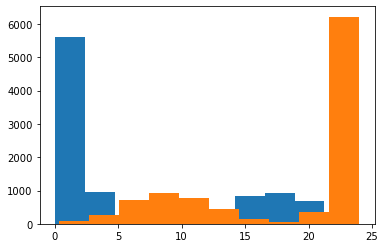

(array([ 989., 1027.,  973., 1013., 1005., 1039.,  986.,  963., 1002.,
        1003.]),
 array([20.00053301, 21.00014164, 21.99975027, 22.9993589 , 23.99896754,
        24.99857617, 25.9981848 , 26.99779343, 27.99740207, 28.9970107 ,
        29.99661933]),
 <BarContainer object of 10 artists>)

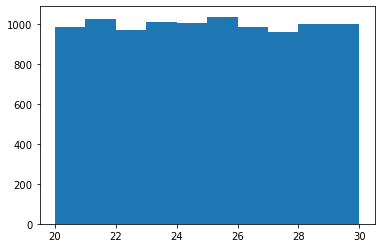

In [7]:
plt.hist(ev_data["ti"])
plt.hist(ev_data["tf"])
plt.show()

plt.hist(ev_data["Q"])

## SSM Matrix

In [6]:
ev_pdf_name[0:2]

['soci', 'socd']

## Simulation

Issues: how to integerate the SSM when using ADNES?

flow_chart:
```{python}
prep grid data:
ADNES: topology,  gen. limits, ramp. limits, line limits,
Outside: gen. cost, ramp. cost,

for $t_{OPF}$ in T (interval: 5min; total: 1h; [n=12]):
    aggregate EV data (from SSM), generate $PR_{e,i,u,t}$
    Do OPF, generate $PG_{i, t}$, $PR_{g, i, u, t}$, $PR_{g, i, d, t}$

    for t in $t_{OPF}$ (interval: 4s; total: 5min; [n=75]):
        Update data into dynamic system:
            # Note, constant power model should be used in TDS.
            # Use TimeSeries as the load. 
            power change: TGOV1.paux0
            load change: 

        Run TDS: generate SFR mileage
```